
# 1. Implementation of online regressor

Here we'll implement a regressor trained with stochastic gradient descent (SGD).

## 1.1. Linear regression and Stochastic Gradient Descent

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.metrics import log_loss, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Implement class `SGDRegressor`. Specification:
- class is inherited from `sklearn.base.BaseEstimator`
- constructor takes parameters `eta` – gradient step ($10^{-3}$ by default) and `n_epochs` – dataset pass count (3 by default)
- constructor also creates `mse_` and `weights_` lists in order to track mean squared error and weight vector during gradient descent iterations
- Class has `fit` and `predict` methods
- The `fit` method takes matrix `X` and vector `y` (`numpy.array` objects) as parameters, appends column of ones to  `X` on the left side, initializes weight vector `w` with **zeros** and then makes `n_epochs` iterations of weight updates (you may refer to this [article](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-8-vowpal-wabbit-fast-learning-with-gigabytes-of-data-60f750086237) for details), and for every iteration logs mean squared error and weight vector `w` in corresponding lists we created in the constructor.
- Additionally the `fit` method will create `w_` variable to store weights which produce minimal mean squared error
- The `fit` method returns current instance of the `SGDRegressor` class, i.e. `self`
- The `predict` method takes `X` matrix, adds column of ones to the left side and returns prediction vector, using weight vector `w_`, created by the `fit` method.

In [2]:
class SGDRegressor(BaseEstimator):
    def __init__(self, eta=1e-3, n_epochs=3):
        self.eta = eta
        self.n_epochs = n_epochs
        self.mse_ = []
        self.weights_ = []
    
    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])

        w = np.zeros(X.shape[1])

        for it in tqdm(range(self.n_epochs)):
            for i in range(X.shape[0]):

                new_w = w.copy()
                new_w[0] += self.eta * (y[i] - w.dot(X[i, :]))
                for j in range(1, X.shape[1]):
                    new_w[j] += self.eta * (y[i] - w.dot(X[i, :])) * X[i, j]
                w = new_w.copy()

                self.weights_.append(w)
                self.mse_.append(mean_squared_error(y, X.dot(w)))

        self.w_ = self.weights_[np.argmin(self.mse_)]

        return self
    
    def predict(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])

        return X.dot(self.w_)

Let's test out the algorithm on height/weight data. We will predict heights (in inches) based on weights (in lbs).

In [3]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
DATA_PATH = 'https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/'

In [4]:
data_demo = pd.read_csv(DATA_PATH + 'weights_heights.csv')

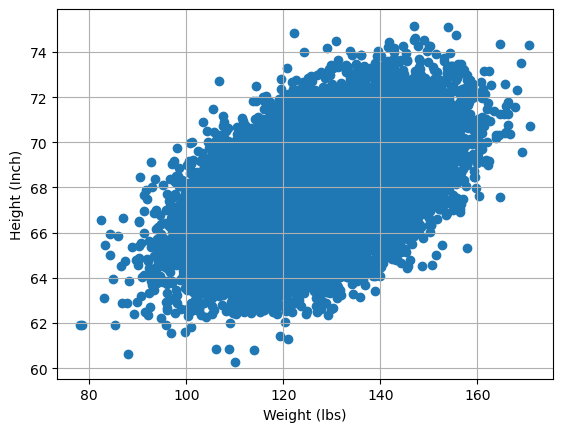

In [5]:
plt.scatter(data_demo['Weight'], data_demo['Height'])
plt.xlabel('Weight (lbs)')
plt.ylabel('Height (Inch)')
plt.grid();

In [6]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

Let 's perform train/test split and scale data.

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([-1, 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([-1, 1]))

Train created `SGDRegressor` with `(X_train_scaled, y_train)` data. We leave default parameter values for now.

In [9]:
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train_scaled, y_train)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.83s/it]


SGDRegressor()

Let's draw a chart with training process  – dependency of mean squared error from the i-th SGD iteration number.

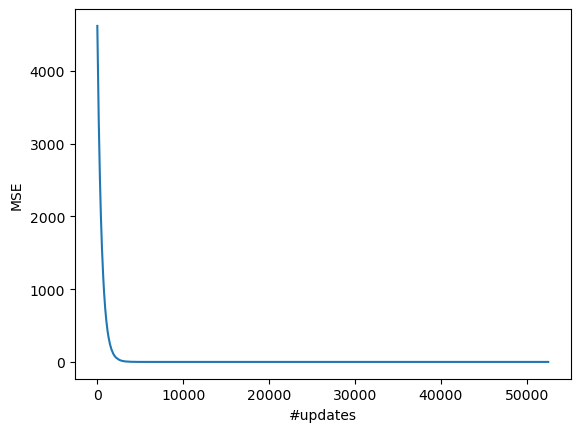

In [10]:
plt.plot(range(len(sgd_reg.mse_)), sgd_reg.mse_)
plt.xlabel("#updates")
plt.ylabel("MSE");

We print the minimal value of mean squared error and the best weights vector.

In [11]:
np.min(sgd_reg.mse_), sgd_reg.w_

(2.7151352406643623, array([67.9898497 ,  0.94447605]))

Let's draw chart of model weights ($w_0$ and $w_1$) behavior during training.

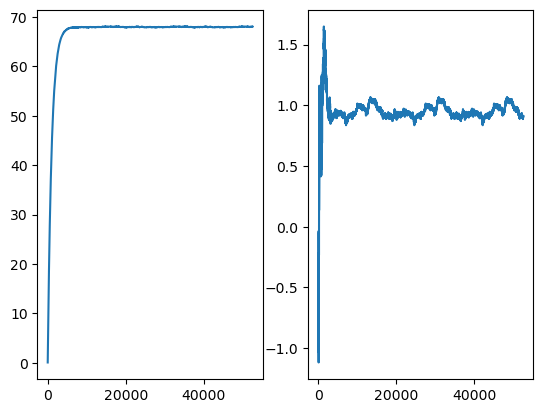

In [12]:
plt.subplot(121)
plt.plot(range(len(sgd_reg.weights_)), [w[0] for w in sgd_reg.weights_])
plt.subplot(122)
plt.plot(range(len(sgd_reg.weights_)), [w[1] for w in sgd_reg.weights_]);

Let's make a prediction for hold-out  set `(X_valid_scaled, y_valid)` and check MSE value.

In [13]:
sgd_holdout_mse = mean_squared_error(y_valid, sgd_reg.predict(X_valid_scaled))
sgd_holdout_mse

2.6708681207033784

Let's do the same thing for `LinearRegression` class from `sklearn.linear_model`. Let's evaluate MSE for hold-out set.

In [14]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression().fit(X_train_scaled, y_train)
print(lm.coef_, lm.intercept_)
linreg_holdout_mse = mean_squared_error(y_valid, lm.predict(X_valid_scaled))
linreg_holdout_mse

[0.94537278] 67.98930834742858


2.670830767667635

In [15]:
try:
    assert (sgd_holdout_mse - linreg_holdout_mse) < 1e-4
    print("Correct!")
except AssertionError:
    print(
        "Something's not good.\n Linreg's holdout MSE: {}"
        "\n SGD's holdout MSE: {}".format(linreg_holdout_mse, sgd_holdout_mse)
    )

Correct!
